In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import jieba
import re

In [2]:
warnings.filterwarnings('ignore')

### Load data

In [3]:
products = pd.read_csv("Cung cap HV/Product_new.csv")
reviews = pd.read_csv("Cung cap HV/Review_new.csv")

In [4]:
products.head(2)

,item_id,name,description,rating,price,list_price,brand,group,url,image
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...


In [5]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4373 entries, 0 to 4372
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      4373 non-null   int64  
 1   name         4373 non-null   object 
 2   description  4370 non-null   object 
 3   rating       4373 non-null   float64
 4   price        4373 non-null   int64  
 5   list_price   4373 non-null   int64  
 6   brand        4373 non-null   object 
 7   group        4373 non-null   object 
 8   url          4373 non-null   object 
 9   image        4373 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 341.8+ KB


In [6]:
products.shape

(4373, 10)

### Data Transformation

In [8]:
products = products[products['name'].notnull()]

In [9]:
products['name_description'] = products.name + products.description

In [10]:
products = products[products['name_description'].notnull()]

In [11]:
products['name_desciption_pre'] = products['name_description'].apply(lambda x: word_tokenize(x,format='text'))

In [12]:
type(products)

pandas.core.frame.DataFrame

In [13]:
products.shape

(4370, 12)

In [14]:
products.head(2)

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_description,name_desciption_pre
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,Tai_nghe Bluetooth_Inpods 12 - Cảm_biến vân ta...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe bluetooth không dây F9 True wireless ...,Tai_nghe bluetooth không dây F9_True wireless ...


In [15]:
products = products.reset_index()

In [16]:
#stopwords
STOP_WORD_FILE = "Cung cap HV/vietnamese-stopwords.txt"

In [17]:
with open(STOP_WORD_FILE,'r',encoding='utf-8') as file:
    stop_words = file.read()
stop_words = stop_words.split('\n')

In [18]:
#TF-IDF
tf = TfidfVectorizer(analyzer='word', min_df=0, stop_words=stop_words)

In [19]:
tfidf_matrix = tf.fit_transform(products.name_desciption_pre)

### Solution 1: Cosine similarity

In [20]:
cosine_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [21]:
cosine_similarity

array([[1.        , 0.36131179, 0.08053821, ..., 0.01781428, 0.00962734,
        0.05741302],
       [0.36131179, 1.        , 0.08326394, ..., 0.01520767, 0.02756314,
        0.08717942],
       [0.08053821, 0.08326394, 1.        , ..., 0.03605742, 0.02343697,
        0.06565407],
       ...,
       [0.01781428, 0.01520767, 0.03605742, ..., 1.        , 0.0063396 ,
        0.03203321],
       [0.00962734, 0.02756314, 0.02343697, ..., 0.0063396 , 1.        ,
        0.04106875],
       [0.05741302, 0.08717942, 0.06565407, ..., 0.03203321, 0.04106875,
        1.        ]])

In [22]:
cosine_similarity.shape

(4370, 4370)

In [23]:
# For each product, get other 10 products correlated mostly
results = {}

for idx, row in products.iterrows():    
    similar_indices = cosine_similarity[idx].argsort()[:-10:-1]
    similar_items = [(cosine_similarity[idx][i], products['item_id'][i]) for i in similar_indices]
    results[row['item_id']] = similar_items[1:]

In [24]:
#List of products correlated with product_id=48102821
results[48102821]

[(0.43740338387278016, 56365197),
 (0.38933473354502074, 22413470),
 (0.3825994474112162, 50319688),
 (0.3718359519194111, 72928043),
 (0.365065019989627, 56885678),
 (0.3613635638335272, 48273751),
 (0.3613117886623281, 52333193),
 (0.3550049997607774, 35607267)]

In [25]:
# Get product information
def getname(id):
    return products.loc[products["item_id"]==id]['name'].to_list()[0].split('-')[0]

In [26]:
# Information of suggested products
def recommendation (item_id,num):
    print('Recommending ' + str(num) + " products similar to " + getname(item_id) + "...")
    print('='*50)
    recs = results[item_id][:num]
    for rec in recs:
        print(rec[1])
        print("Recommended: product id:" + str(rec[1]) + ", " + getname(rec[1]) + " (score:" + str(rec[0]) + ")")  

In [27]:
recommendation(48102821,5)

Recommending 5 products similar to Tai nghe Bluetooth Inpods 12 ...
56365197
Recommended: product id:56365197, Tai nghe bluetooth không dây i12 TWS 5.0, thiết kế nhỏ gọn, chất lượng âm thanh nổi HIFI, chức năng giảm tạp âm (score:0.43740338387278016)
22413470
Recommended: product id:22413470, Tai Nghe Bluetooth Air.podes Cảm Ứng Công Nghệ Cao 5.0 (score:0.38933473354502074)
50319688
Recommended: product id:50319688, Tai Nghe Bluetooth Mini I12 Tws V5.0 (Trắng) Nút Cảm Ứng, Có Pop (score:0.3825994474112162)
72928043
Recommended: product id:72928043, Tai Nghe Bluetooth Amoi F9 kèm Củ Sạc 1A và Cáp Sạc cho Dock Sạc 3500mAh (score:0.3718359519194111)
56885678
Recommended: product id:56885678, Tai Nghe Bluetooth TWS F9 Tai Nghe Nhét  Hai Tai  Bluetooth 5.0  True wireless   Cảm Ứng Vân Tay, Nút Bấm Chống Nước Dock Sạc Dự Phòng   + Túi đựng tai nghe  (score:0.365065019989627)


### WordCloud

In [28]:
from wordcloud import WordCloud, STOPWORDS

In [29]:
def get_product_text(item_id,num):
    text = []
    for v in results[item_id][:num]:
        rcm_id = v[1] 
        text.append(getname(rcm_id))
    text = str(text)
    return text

In [30]:
wordcloud_text = get_product_text(48102821,5)
wordcloud_text

"['Tai nghe bluetooth không dây i12 TWS 5.0, thiết kế nhỏ gọn, chất lượng âm thanh nổi HIFI, chức năng giảm tạp âm', 'Tai Nghe Bluetooth Air.podes Cảm Ứng Công Nghệ Cao 5.0', 'Tai Nghe Bluetooth Mini I12 Tws V5.0 (Trắng) Nút Cảm Ứng, Có Pop', 'Tai Nghe Bluetooth Amoi F9 kèm Củ Sạc 1A và Cáp Sạc cho Dock Sạc 3500mAh', 'Tai Nghe Bluetooth TWS F9 Tai Nghe Nhét  Hai Tai  Bluetooth 5.0  True wireless   Cảm Ứng Vân Tay, Nút Bấm Chống Nước Dock Sạc Dự Phòng   + Túi đựng tai nghe ']"

In [31]:
wc=WordCloud(background_color='Black',max_words=2000,stopwords=STOPWORDS)

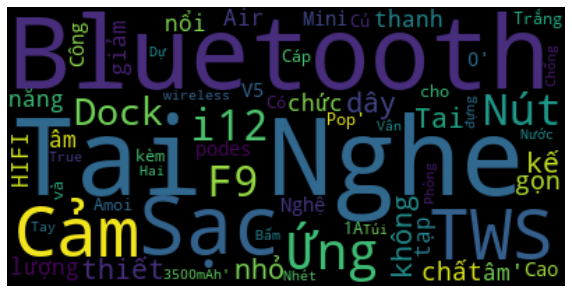

In [33]:
# Wordcloud của group 0 (sport)
wc.generate(wordcloud_text)
plt.figure(figsize=(10,12))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

### Save result

In [34]:
info = []
for p_id, v in results.items():
    for item in v:
        info.append({
            'product_id': p_id,
            'rcmd_product_id': item[1],
            'score': item[0]
        })
content_based_df = pd.DataFrame(info)

In [35]:
content_based_df.to_csv("CB_cosinesimilarity.csv")